# Supervised Learning - Regression Example

### Overview
This program will make use of the Fish Market dataset, which can be [downloaded here](https://www.kaggle.com/aungpyaeap/fish-market), to be able to predict the weight of a given fish based on its species, height, width and 3 measurements of length. Note: make sure the dataset (the .csv file) is in the same directory as the notebook.

### Importing Libraries
The first 2 lines show off some cool features with Notebooks:
  1. Lines starting with % are instructions to Jupyter, here we tell it to load the TensorBoard extension which allows us to embed TensorBoard visualisations right into the notebook - instead of opening a new webpage. TensorBoard is a visualisation tool for TensorFlow which allows us to look at the machine learning model and the training performance.
  2. Lines starting with ! are normal terminal commands, here it will make sure seaborn and pandas is installed, without having to separately opening a terminal and installing them.

**Libraries Used:**
 - Matplotlib is a library for creating graphs and other visuals
 - Numpy is a high-performance mathematics library
 - Pandas is a library for working with datasets
 - Seaborn works with matplotlib to create some nice combined graphics
 - TensorFlow is the platform that the AI code will run on, with Keras being the interface to TF

In [1]:
%load_ext tensorboard
!pip install -q seaborn pandas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.1.0


### Reading & Formatting the Dataset
Lets start by loading the CSV dataset into a pandas dataframe. A dataframe is simply a 2-dimensional tabular data-type with some powerful functions which we will use some of later.

Once loaded, we can use the .tail() function to print the last few lines of the dataframe so we can learn about the structure

In [2]:
rawDS = pd.read_csv("Fish.csv")
rawDS.tail()

,Species,Weight,Length1,Length2,Length3,Height,Width
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672
158,Smelt,19.9,13.8,15.0,16.2,2.9322,1.8792


From looking at the structure, there is one issue that needs to be fixed before we can work with the data. Computers like working with numbers, not words, so we need to do something about the species column. We could just not use it, but the species of a fish is likely to be quite important to its weight. 

Instead we will split that column (called catergorical column) into a column for each species called dummy columns as its values will be either 1 if it is that species or 0 otherwise. 

First we make a copy of the dataset so we can refer back to the original later without re-reading the file. Then we can use Pandas' .get_dummies() function to create all dummy columns where needed. We pass the dataset as well as the prefix and prefix separator we want for the new columns, by default it would use e.g. 'Species_Bream'

We print the tail of the dataframe and we can see the new structure

In [3]:
ds = rawDS.copy()
ds = pd.get_dummies(ds, prefix='', prefix_sep='')
ds.tail()

,Weight,Length1,Length2,Length3,Height,Width,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
154,12.2,11.5,12.2,13.4,2.0904,1.3936,0,0,0,0,0,1,0
155,13.4,11.7,12.4,13.5,2.4300,1.2690,0,0,0,0,0,1,0
156,12.2,12.1,13.0,13.8,2.2770,1.2558,0,0,0,0,0,1,0
157,19.7,13.2,14.3,15.2,2.8728,2.0672,0,0,0,0,0,1,0
158,19.9,13.8,15.0,16.2,2.9322,1.8792,0,0,0,0,0,1,0


### Dataset Visualisation
The SeaBorn module is able to produce pair plots to make it easy to visualise any correlations between the features.

Here we just look at the relations between the weight, height and width and it's pretty apparent there are relations between the variables, but also shows we couldn't just use the height and width to predict the weight as seen in the plots that have 2 or 3 branches.

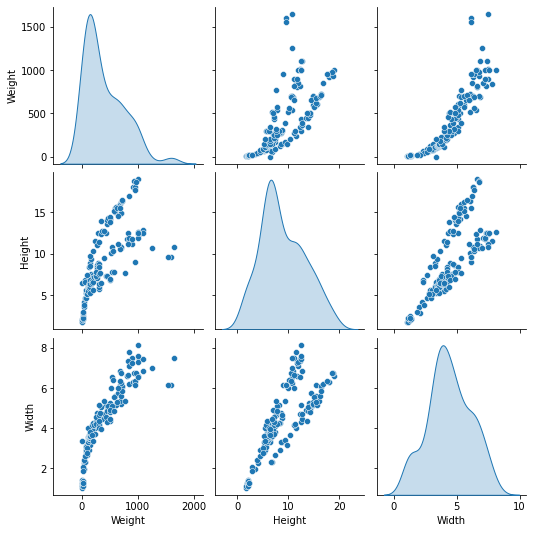

In [4]:
sb.pairplot(ds[['Weight', 'Height', 'Width']], diag_kind='kde')

### Creating the Training and Testing Dataset

Now we're happy with the structure of the data, we need to divide it into 2 sets for the testing and training data, and then divide those into features and labels.

The training data is what the program uses to train the machine learning model, and the test data is to test the performance of that model on unseen data. 

We create the training dataset using the .sample() function with the 'frac' parameter 0.8 to specify we want 80% of the original datset.

We can then create the testing datset by taking the original dataset and dropping (i.e. removing) any rows that is in the training datset by removing rows with indexes that are also in the training set.

Finally we separate the datasets we just created into features and labels by copying them into Features dataset, and then popping the Weight column of Features into a new Labels set.

In [5]:
trainDS = ds.sample(frac=0.8)
testDS = ds.drop(trainDS.index)

trainFeatures = trainDS.copy()
testFeatures = testDS.copy()

trainLabels = trainFeatures.pop('Weight')
testLabels = testFeatures.pop('Weight')

### Building Our Linear Regression Model

To build a model in TensorFlow you design them as a 'Graph' using Keras, the high-level API for TensorFlow. We start of by instantiating a sequential model which is the basic model type.

We need to normalise the data as each column contains a different range of values, meaning that features containing larger values can over-power the others and be seen as more important. Obviously we want all the features to be as equal as eachother so the model can decide what is important.

To do this, we instantiate a normalization layer, and tell it to 'adapt' to the data by passing the input training data to it. Now configured, we can add the layer to the model.

To combine the inputs to form one output, we use a 'dense' layer, the simplest layer type, with 1 node which will be the output. To calculate the output, the node will take each input and multiply it by the 'weight' of the connection from the source to this node, and then sum all the calculations. The weight is a parameter the model will change during training to define how important each input is to the final value.

##### Simple example of how this works:
Assume we have a model with one input, the weight can be represented as the m in y = mx. During training, y is the label you are given and x is the input, so you use that to calculate the value of m. During testing, you multiply the input x by the calculated weight m to get the predicted output.

In [6]:
model = keras.Sequential()

normaliser = tf.keras.layers.experimental.preprocessing.Normalization()
normaliser.adapt(np.array(trainFeatures))

model.add(normaliser)

model.add(keras.layers.Dense(units=1))


Now we have designed the model, we compile it using the Adam optimiser. 0.1 is a good learning rate to start with, it defines how much the model will change its parameters during training. Too small and it can get stuck in local minima, too large it can jump over the global minima. You can tweak this value and see how accurate you can get this model. 
The loss parameter defines which function to use to calculate the loss (the error) which is used by the optimiser.

##### How do Optimisers work?

Imagine you plotted all the possible parameters in the model against the loss/error. You get a line graph and it is the goal of the optimiser to find the lowest point of the graph - i.e. find the set of parameters which give the lowest error. 

The easiest way to do this is through something called *gradient descent*, it works by picking a point and calculating the gradient, you then travel downwards at a jump relative to the steepness of this point - the steeper the line the further away it is from a minima so you should be able to jump further. The learning rate also contributes to how much it travels. The graph will typically consist of multiple inflection points, but the model can find it hard to find the inflection that is the minimum of the graph (the parameters with the least errors), so it could either skip past the global minimum if the learning rate is too high and have to go backwards, or get stuck in a local minimum if it is too low. T

The Adam optimiser we are using here is an implementation of gradient descent that is known for being resource efficient with low memory requirements.

In [7]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

#### Training the model

Using the %% prefix, we tell Jupyter to measure and output the time it takes to run this cell - its a good thing to know, especially when making tweaks to the model and want to compare the time taken to train and the performance you get out of it.

We define a callback function which will be used during traning to generate a TensorBoard log of this model. As mentioned TensorBoard is a visualisation tool that is part of TensorFlow, during training the callback function is used to generate a log file which can then be opened by the TensorBoard web-app to see the performance change during training and validation, diagram of the model 

The % prefix is the Jupyter command telling it to embed the TensorBoard webapp into the notebook rather than opening another window

In [8]:
%%time
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs\\test", histogram_freq=1)
history = model.fit(np.array(trainFeatures), np.array(trainLabels), verbose=0, epochs=1500, validation_split = 0.2, callbacks=[tensorboard_callback])
%tensorboard --logdir logs/test

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 12132.

Wall time: 1min 20s


### Evaluating the Trained Model
Now the model has been trained, we can evaluate it by testing it using the test dataset. We call the evaluate method on the model passing the test dataset features and labels.

The loss value outputted is the average difference between the predicted weight and the actual weight - I was getting ~70 meaning that the average difference between the predicted and actual weight was around 

In [9]:
modelEval = model.evaluate(testFeatures, testLabels)

32/32 [==============================] - 0s 1ms/sample - loss: 68.2768


We can also plot the actual and predicted weight for each row in the test dataset onto a line graph. It's a nice visual way to see the performance of the model, it's pretty clear it was pretty good but some outliers are visible.

To create the graph, we first tell the model to calculate the predictions for all of the test dataset and put it into a results variable. We then use MatPlotLib to create a has a scatter plot of the test dataset labels against the results we just predicted, and also tell it to plot a y=x line (which would be where all the values *should* sit if it were 100% accurate)

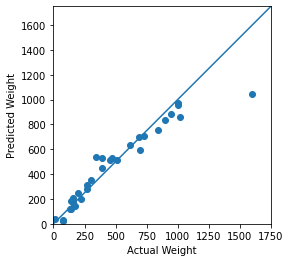

In [10]:
results = model.predict(testFeatures)
a = plt.axes(aspect='equal')
plt.scatter(testLabels, results)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
lims = [0, 1750]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

### Building our Deep Neural Network Regression Model

Now we build the deep neural network version of a regression model. Again we will use the Sequential model type, as well as using the same normaliser as before, but this time we are adding 2 dense layers, known as hidden layers, between the normaliser and the dense output.

Each hidden layer has 64 nodes each. As the number of nodes increases, and so the number connections/weights, the model gets better working with more and more complex relations between the inputs. However, too many nodes, and thus too many connections, can cause the model to *over-fit*, this is where the model 'tunnels' on the training data and cannot generalise on new data. Also increasing the number of connections increases the computation time and memory needed to train and run the model. It is therefore important to find a good number of nodes for each layer which is typically done through trial and error.

The hidden layers also use the relu activation function. Activation functions are applied on each node afte they have computed the sum of the weights \* inputs. It maps that number to a range typically -1 to 1, or 0 to 1. Neurons in a real brain have to choose when to fire and how strongly to fire based on its inputs, and activation functions do the same thing.

Again, we will also use the same loss and optimiser functions as before

In [11]:
dnnModel = tf.keras.Sequential([normaliser, tf.keras.layers.Dense(64, activation='relu'), tf.keras.layers.Dense(64, activation='relu'), tf.keras.layers.Dense(1)])
dnnModel.compile(optimizer = tf.keras.optimizers.Adam(0.01), loss='mean_absolute_error')


And now we can train the DNN model, again we define the TensorBoard callback function which shows us the training performance graph, as well as other visualisations.

In [12]:
%%time
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs\\dnn", histogram_freq=1)
dnnHistory = dnnModel.fit(np.array(trainFeatures), np.array(trainLabels), validation_split = 0.2, verbose=0, epochs=1500, callbacks=[tensorboard_callback])
%tensorboard --logdir logs/dnn


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 10484.

Wall time: 1min 25s


#### Evaluating the DNN Regression Model

Using the same evaluate method on the DNN model gives me a loss of around 41, with is approximately 70% better than the linear regression model!

In [13]:
modelEval = dnnModel.evaluate(testFeatures, testLabels)

32/32 [==============================] - 0s 2ms/sample - loss: 44.2702


We can also show another graph, but this time has the DNN regression model as well as the linear regression model. It clearly shows the DNN model being more accurate.

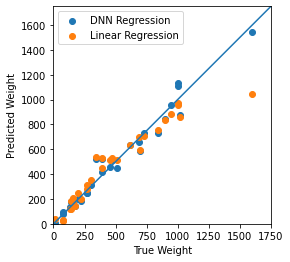

In [14]:
dnnResults = dnnModel.predict(testFeatures).flatten()
a = plt.axes(aspect='equal')
a.scatter(testLabels, dnnResults, label='DNN Regression')
a.scatter(testLabels, results, label='Linear Regression')
a.legend()
plt.xlabel('True Weight')
plt.ylabel('Predicted Weight')
lims = [0, 1750]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Using our Models

Now that we have created & trained our models - they are ready for use. There are ways to save/package and distribute trained models so they do not need to be trained every time which will be demonstrated in another article.

Here we will just use a collection of input statements to get the measurements from the user, run that through both models and get the predicted weight value - not a very elegant solution but it can easily replaced with a UI, or by a web request etc.

In [ ]:
inpLength1 = float(input("Length 1 (Vertical Length) : "))
inpLength2 = float(input("Diagonal 2 (Vertical Length) : "))
inpLength3 = float(input("Cross 3 (Vertical Length) : "))
inpHeight = float(input("Height (Vertical Length) : "))
inpWidth = float(input("Width (Vertical Length) : "))
inpSpecies = input("Species (Parkki, Perch, Pike, Roach, Smelt or Whitefish) : ")

if inpSpecies.lower() == "bream":
    inpSpecies = [1,0,0,0,0,0,0]
elif inpSpecies.lower() == "parkki":
    inpSpecies = [0,1,0,0,0,0,0]
elif inpSpecies.lower() == "perch":
    inpSpecies = [0,0,1,0,0,0,0]
elif inpSpecies.lower() == "pike":
    inpSpecies = [0,0,0,1,0,0,0]
elif inpSpecies.lower() == "roach":
    inpSpecies = [0,0,0,0,1,0,0]
elif inpSpecies.lower() == "smelt":
    inpSpecies = [0,0,0,0,0,1,0]
elif inpSpecies.lower() == "whitefish":
    inpSpecies = [0,0,0,0,0,0,1]
else:
    print("Incorrect Species")

inp = [inpLength1] + [inpLength2] + [inpLength3] + [inpHeight] + [inpWidth] + inpSpecies 
                   


In [ ]:
print("Linear Regression Model Predicts : " + str(model.predict([inp])[0][0]))
print("DNN Regression Model Predicts : " + str(dnnModel.predict([inp])[0][0]))